# Web Intrusion Detection

In [13]:
from __future__ import division, print_function
## to ignore warnings as we don't like them as such
import warnings
warnings.filterwarnings('ignore')
#plotting lib's
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
#other's
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_predict, TimeSeriesSplit
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.metrics import confusion_matrix
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score , roc_curve, auc
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [14]:
# Read the training and test data sets
train_df = pd.read_csv('Project 1/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/train_sessions.csv',
                       index_col='session_id',parse_dates=['time1'])
test_df = pd.read_csv('Project 1/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/test_sessions.csv',
                      index_col='session_id',parse_dates=['time1'])

times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]

In [15]:
train_df.shape, test_df.shape

((253561, 21), (82797, 20))

In [16]:
train_df.value_counts()

site1  time1                site2  time2                site3  time3                site4   time4                site5    time5                site6   time6                site7  time7                site8   time8                site9   time9                site10  time10               target
953    2014-03-19 09:03:10  953.0  2014-03-19 09:03:11  953.0  2014-03-19 09:03:12  953.0   2014-03-19 09:03:13  953.0    2014-03-19 09:03:14  953.0   2014-03-19 09:03:15  953.0  2014-03-19 09:03:16  953.0   2014-03-19 09:03:17  953.0   2014-03-19 09:03:18  953.0   2014-03-19 09:03:19  0         3
       2014-03-26 09:30:22  953.0  2014-03-26 09:30:23  953.0  2014-03-26 09:30:24  953.0   2014-03-26 09:30:25  953.0    2014-03-26 09:30:26  953.0   2014-03-26 09:30:27  953.0  2014-03-26 09:30:28  953.0   2014-03-26 09:30:29  953.0   2014-03-26 09:30:30  953.0   2014-03-26 09:30:31  0         2
       2014-02-26 09:55:21  953.0  2014-02-26 09:55:22  953.0  2014-02-26 09:55:23  953.0   2014-02-26 09:55

In [17]:
test_df.value_counts()

site1  time1                site2    time2                site3    time3                site4    time4                site5    time5                site6    time6                site7    time7                site8    time8                site9    time9                site10   time10             
1      2014-05-02 08:25:11  37.0     2014-05-02 08:25:11  31.0     2014-05-02 08:25:12  39.0     2014-05-02 08:25:12  37.0     2014-05-02 08:25:12  22.0     2014-05-02 08:25:12  29.0     2014-05-02 08:25:12  22.0     2014-05-02 08:25:13  37.0     2014-05-02 08:25:13  21.0     2014-05-02 08:25:16    1
890    2014-09-04 14:54:56  143.0    2014-09-04 14:54:56  2874.0   2014-09-04 14:54:56  156.0    2014-09-04 14:54:56  559.0    2014-09-04 14:54:56  2868.0   2014-09-04 14:54:56  2871.0   2014-09-04 14:54:57  76.0     2014-09-04 14:54:57  559.0    2014-09-04 14:54:57  30.0     2014-09-04 14:54:57    1
891    2014-07-02 11:22:28  891.0    2014-07-02 11:22:29  1086.0   2014-07-02 11:22:29  14.0     20

<Axes: xlabel='target', ylabel='count'>

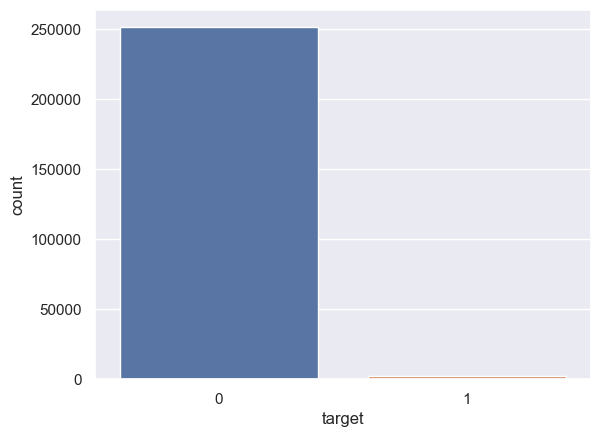

In [18]:
sns.countplot(x =train_df['target']) #Imbalanced Dataset

In [19]:
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

In [22]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros

train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# Load websites dictionary
with open(r"Project 1/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])

Websites total: 48371


In [23]:
# Top websites in the training data set
top_sites = pd.Series(train_df[sites].fillna(0).values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
top_sites

21     123776
0      122730
23      87619
782     77055
22      58258
Name: count, dtype: int64

In [24]:
# Alice's preferences
top_sites_alice = pd.Series(train_df[train_df.target==1][sites].fillna(0).values.flatten()
                           ).value_counts().sort_values(ascending=False).head()
top_sites_alice

77    1382
80    1354
76    1307
29     897
21     857
Name: count, dtype: int64

In [25]:
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

# Find sessions' starting and ending
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

In [26]:
time_df_test = pd.DataFrame(index=test_df.index)

# Find sessions' starting and ending
time_df_test['min'] = test_df[times].min(axis=1)
time_df_test['max'] = test_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df_test['seconds'] = (time_df_test['max'] - time_df_test['min']) / np.timedelta64(1, 's')

- y_train - our target variable 

- full_df - the merged table of input data (training and test samples together) 

* idx_split - the index by which we will separate the training sample from the test


In [27]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

#full_df[:].fillna(method='bfill',inplace=True)

# Index to split the training and test data sets
idx_split = train_df.shape[0]

In [28]:
full_df.head(5)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,945,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,946,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,952,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22


In [29]:
full_sites = full_df[sites] #only sites
full_sites.head(3)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946


## Creating characteristics

- Extracting attributes from the site table 

- Count the number of unique sites in each session

In [30]:
%%time
#Getting Unique Counts
unique_count = []
for row in full_sites.values:
    unique = np.unique (row)
    if 0 in unique:
        unique_count.append(len(unique) - 1)
    else:
        unique_count.append(len(unique))
unique_count = np.array(unique_count).reshape(-1,1)

CPU times: total: 2.27 s
Wall time: 3.85 s


In [31]:
unique_count[:10] #print few

array([[2],
       [2],
       [6],
       [5],
       [6],
       [5],
       [5],
       [6],
       [5],
       [8]])

In [32]:
additional_data_df  =  pd.DataFrame(data = unique_count ,columns = ['unique'],index = full_df.index ) #my features dataframe

Create a dictionary where the keys are sites, and the values ​​- the number of sessions in which this site met.

In [33]:
site_dict  =  {} 
for  row  in  full_sites . values : 
    for  site_id  in  np . unique ( row ): 
        if  site_id  in  site_dict : 
            site_dict [ site_id ]  +=  1 
        else : 
            site_dict [ site_id ]  =  1 
site_dict.pop(0)

30500

Make the presence indicator in the site of the site, which is included in the top 10 popular sites

In [34]:
%%time
top_10 = sorted (list (site_dict.items ()), key = lambda tup: tup [1], reverse = True) [: 10]
top_10 = [element [0] for element in top_10]
have_top_10 = np.zeros ((full_sites.shape [0], 1), dtype = int)
ind = 0
for row in full_sites.values:
    unique = np.unique (row)
    for site_id in unique:
        if site_id in top_10:
            have_top_10[ind] = 1
    ind += 1

have_top_10

CPU times: total: 1.59 s
Wall time: 3.32 s


array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [35]:
additional_data_df [ 'have_top_10' ]  =  have_top_10

In [36]:
additional_data_df.head(3)

,unique,have_top_10
session_id,,
21669,2,0
54843,2,0
77292,6,0


Count the number of absolutely unique sites in the session (the sites met only in this session)

In [37]:
absolutely_unique_count  =  np.zeros((full_sites.shape[0], 1 ), dtype = int ) 
ind  =  0 
for  row  in  full_sites . values : 
    unique  =  np . unique ( row ) 
    absolutely_unic_row  =  {} 
    for  site_id  in  unique : 
        if (site_id !=0) and (site_dict[site_id] == 1) and (site_id not in absolutely_unic_row ): 
            absolutely_unique_count [ ind ]  +=  1 
            absolutely_unic_row [ site_id ]  =  1 
    ind  +=  1
absolutely_unique_count

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [38]:
additional_data_df['absolutely_unique_count'] = absolutely_unique_count

Make an indicator of the presence of an absolutely unique site in the session

In [39]:
absolutely_unique = (absolutely_unique_count > 0 ).astype(int)

In [40]:
additional_data_df ['have_absolutely_unique' ] = absolutely_unique

<Axes: xlabel='absolutely_unique_count', ylabel='count'>

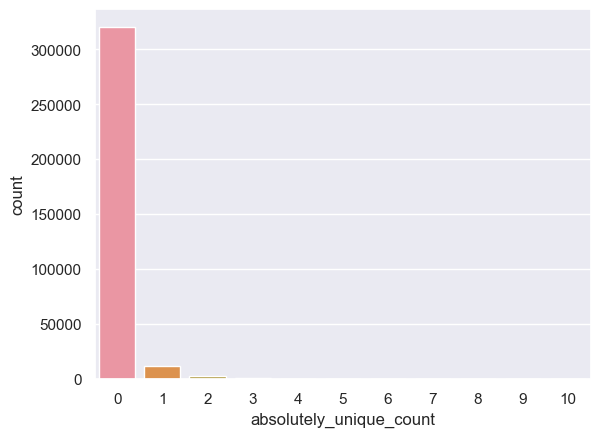

In [42]:
sns.countplot(x = additional_data_df['absolutely_unique_count'])

### Work over time 

- We extract a table in which there will be only columns of time

In [43]:
full_time  =  full_df[times] 
full_time.head(3)

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
session_id,,,,,,,,,,
21669,2013-01-12 08:05:57,2013-01-12 08:05:57,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
54843,2013-01-12 08:37:23,2013-01-12 08:37:23,2013-01-12 09:07:07,2013-01-12 09:07:09,NaT,NaT,NaT,NaT,NaT,NaT
77292,2013-01-12 08:50:13,2013-01-12 08:50:14,2013-01-12 08:50:15,2013-01-12 08:50:15,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,2013-01-12 08:50:17


**We calculate the time of staying on each site within one session**

In [44]:
def  get_time_diff (row): 
    time_length = row.shape[0] - 1 
    time_diff = [0]*time_length 
    i = 0 
    while (i < time_length)and pd.notnull(row[i+1]): 
        time_diff[i] = (row[i+1] - row[i]) /np.timedelta64(1,'s') 
        i += 1 
    return  time_diff

In [45]:
%%time
time_diff = []
for row in full_time.values:
    time_diff.append (get_time_diff (row))
time_diff = np.log1p(np.array(time_diff).astype(float))

CPU times: total: 10.3 s
Wall time: 16.3 s


In [46]:
## Appending The Newly Created Features
time_names = ['time_diff'+str(j) for j in range(1,10)] 
for ind,column_name in enumerate(time_names): 
    additional_data_df[column_name] = time_diff[:,ind] 

**We will calculate the total time spent at each session**

In [47]:
def get_total_time(row): 
    time_length = row.shape[0] - 1 
    i = time_length 
    while pd.isnull( row [ i ]): 
        i -= 1 
    return (row[i] - row[0]) / np.timedelta64(1,'s')

In [48]:
%%time
total_time = []
for row in full_time.values:
    total_time.append(get_total_time(row))
total_time = np.array(total_time).reshape(-1,1).astype(int)

CPU times: total: 1.19 s
Wall time: 2.08 s


In [49]:
additional_data_df['total_time'] =  total_time 
additional_data_df['total_time'] =  np.log1p(additional_data_df['total_time'].values)

In [50]:
additional_data_df['start_hour']  =  full_time['time1'].apply(lambda ts: ts.hour) 
additional_data_df['holiday']     = (full_time['time1'].dt.dayofweek >= 5).astype(int) 
additional_data_df['day_of_week'] = (full_time['time1'].dt.dayofweek).astype(int)

In [51]:
additional_data_df.head(5)

,unique,have_top_10,absolutely_unique_count,have_absolutely_unique,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,total_time,start_hour,holiday,day_of_week
session_id,,,,,,,,,,,,,,,,,
21669,2,0,0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,8,1,5
54843,2,0,0,0,0.000000,7.487174,1.098612,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,7.488294,8,1,5
77292,6,0,0,0,0.693147,0.693147,0.000000,0.693147,0.0,0.000000,0.000000,0.693147,0.000000,1.609438,8,1,5
114021,5,0,0,0,0.000000,0.693147,0.000000,0.000000,0.0,0.693147,0.000000,0.000000,0.693147,1.386294,8,1,5
146670,6,0,0,0,0.000000,0.000000,0.693147,0.000000,0.0,0.000000,0.693147,0.000000,0.000000,1.098612,8,1,5


In [52]:
add_data_train = additional_data_df[: idx_split ].copy() 
add_data_test  = additional_data_df[ idx_split :]

### Analysis of training and test samples 

In [53]:
add_data_train.loc[:, 'target' ]= y_train

**Let's see what signs we have**

In [54]:
dtype_df = add_data_train.dtypes.reset_index() 
dtype_df.columns = ['Column_name','Column_type'] 
dtype_df

,Column_name,Column_type
0,unique,int32
1,have_top_10,int32
2,absolutely_unique_count,int32
3,have_absolutely_unique,int32
4,time_diff1,float64
5,time_diff2,float64
6,time_diff3,float64
7,time_diff4,float64
8,time_diff5,float64
9,time_diff6,float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


target
0    251264
1      2297
Name: count, dtype: int64


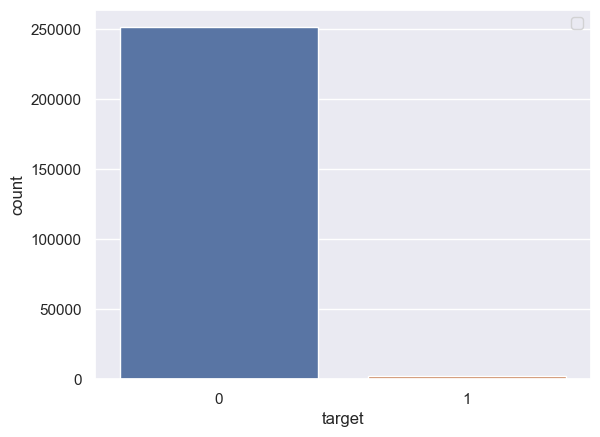

In [56]:
sns.countplot(x = add_data_train['target']) ;plt.legend();
print(add_data_train['target'].value_counts())

**All characteristics are of type int, but they can be divided into two groups-**
- **categorical **

- ** quantitative.**

target
0    251264
1      2297
Name: count, dtype: int64


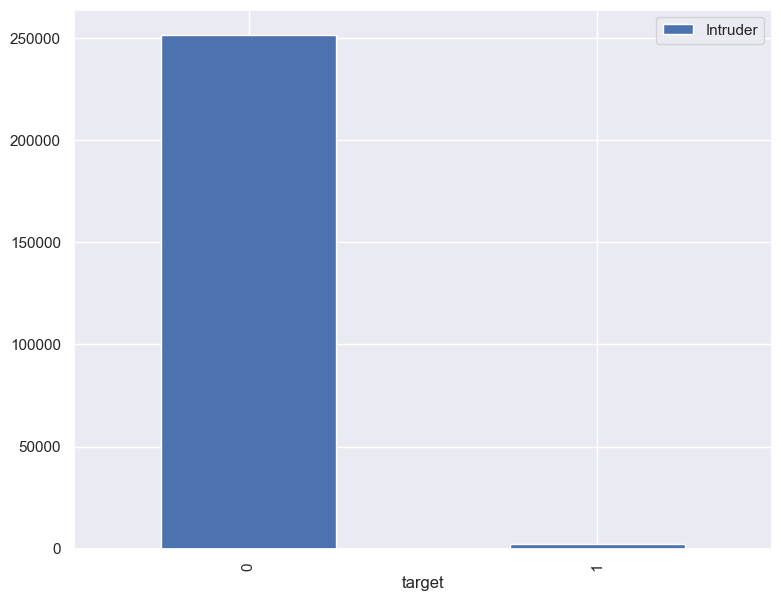

In [57]:
plt.figure(figsize=(9,7))
add_data_train['target'].value_counts().plot(kind = 'bar', label = 'Intruder')
plt.legend()
print(add_data_train['target'].value_counts())

**As you can see, we have two unbalanced classes**

**Let's look at the correlation table of the dataset**

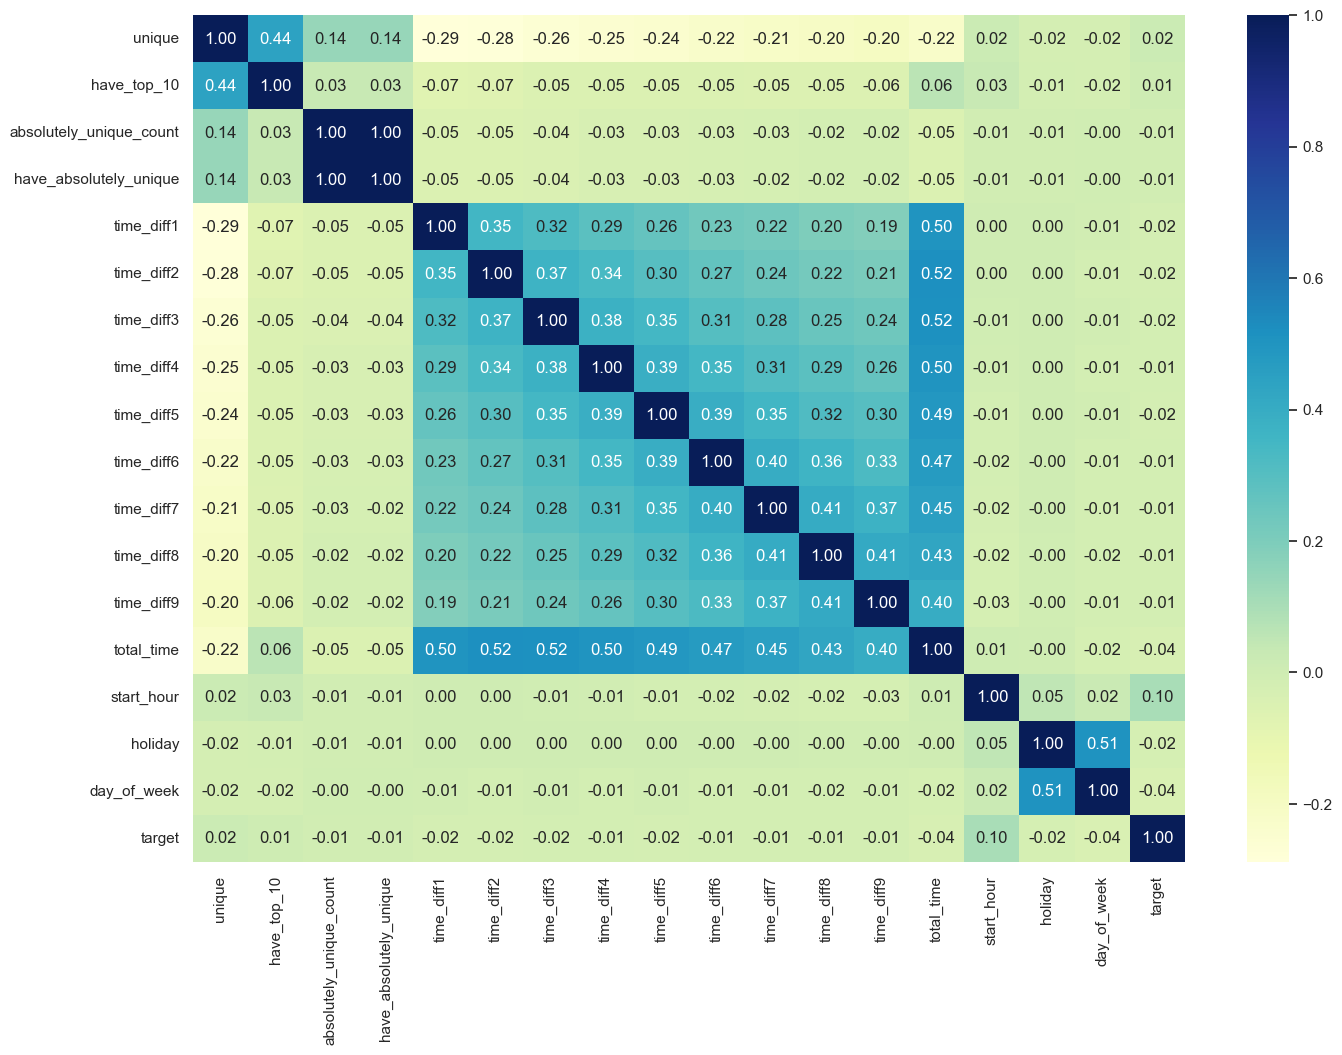

In [58]:
corr = add_data_train.corr('spearman') 
plt.figure(figsize = ( 16 , 11 )) 
sns.heatmap(corr,annot=True,fmt='.2f',cmap="YlGnBu");

**Let's look at the distribution of some features**

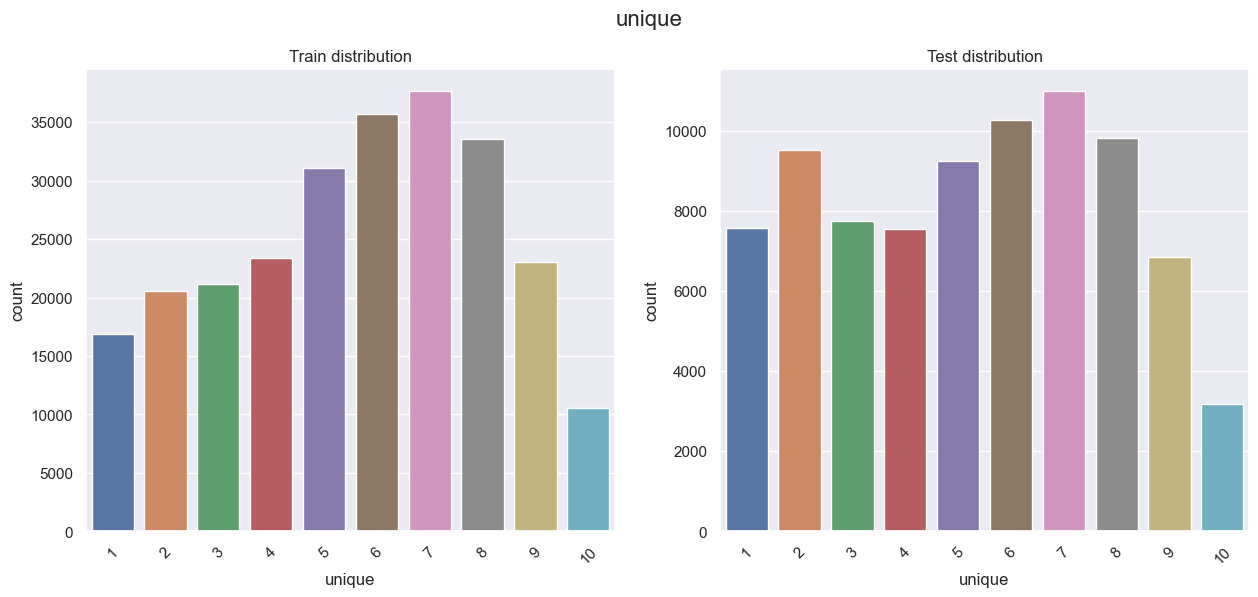

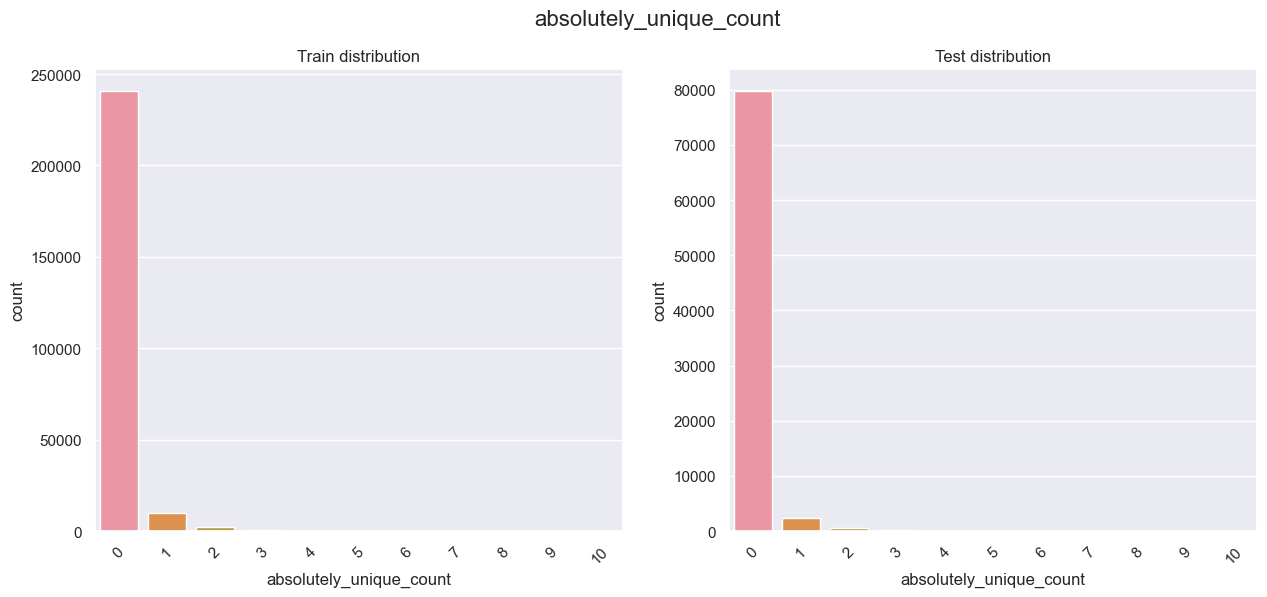

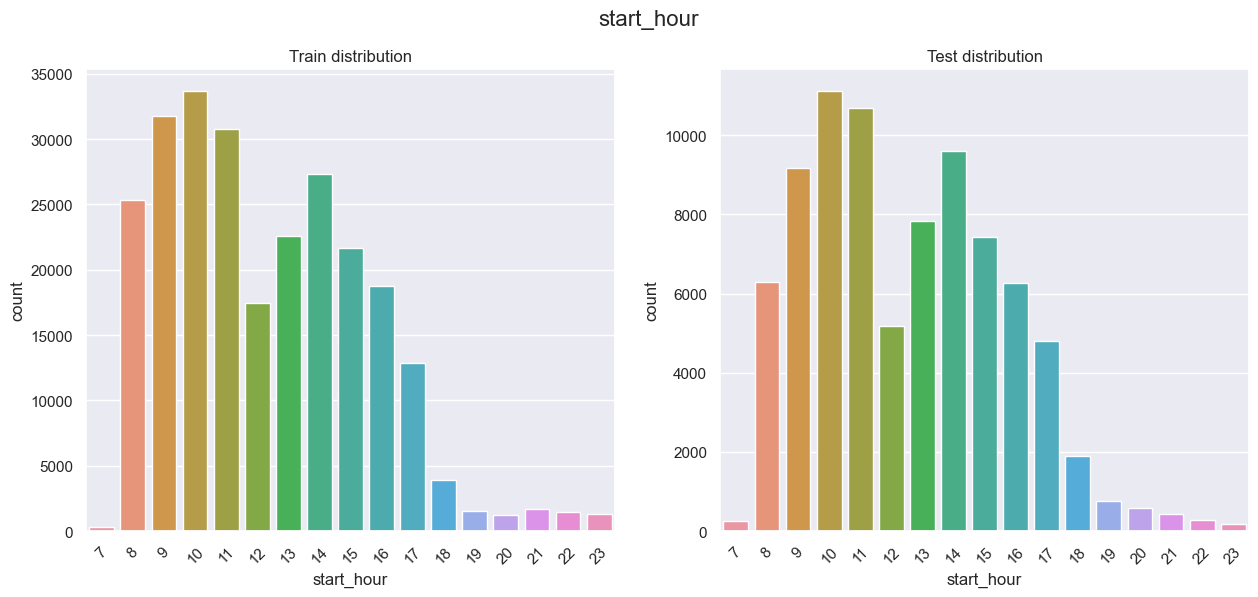

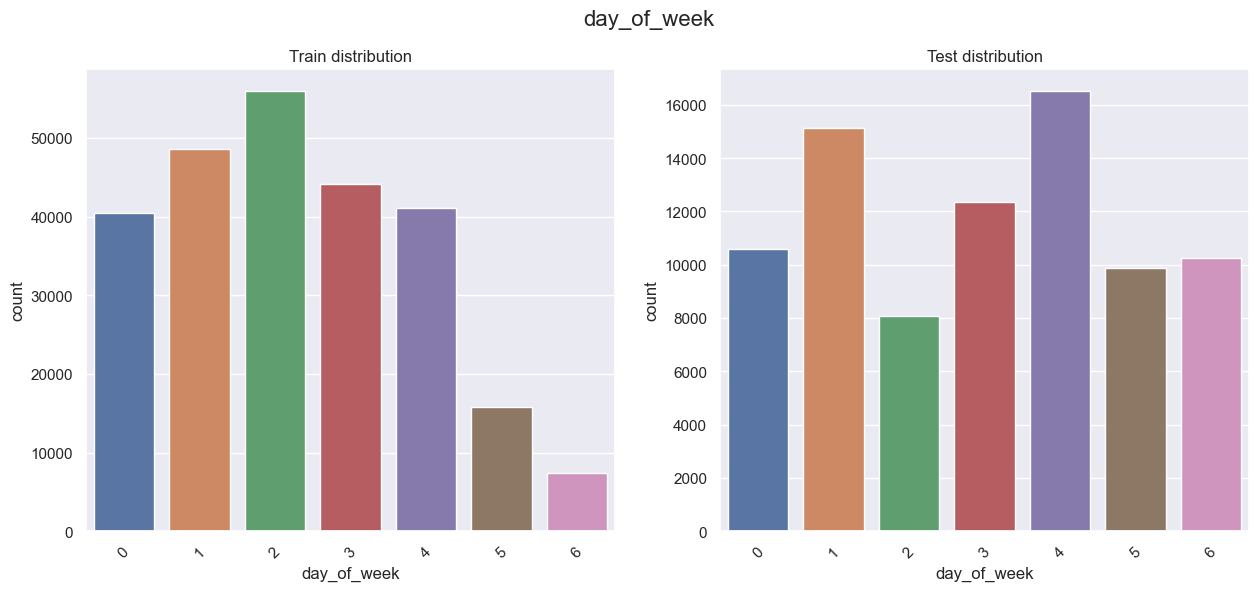

In [60]:
feature_list = ['unique','absolutely_unique_count','start_hour','day_of_week'] 
for  column_name in feature_list: 
    fig , (ax1,ax2) = plt.subplots(1,2,figsize = ( 15 , 6 )) 
    fig.suptitle(column_name,fontsize=16) 
    sns.countplot(x = add_data_train[column_name],ax=ax1) 
    ax1.set_title("Train distribution") 
    for tick in ax1.get_xticklabels(): 
        tick.set_rotation(45)
    sns.countplot(x = add_data_test[column_name],ax=ax2) 
    ax2.set_title("Test distribution") 
    for tick in ax2.get_xticklabels(): 
        tick.set_rotation(45)

- As you can see, all the attributes are distributed approximately equally in the training and test sample. 

- The start_hour attribute is distributed from 7 to 23 hours, and not from 0 to 23 hours, as expected.

- We will analyze the effect of the characteristics on the target variable

In [61]:
def get_target_dist( column_name ): 
    fig , (ax1,ax2) = plt.subplots(1,2,figsize = (15,6)) 
    fig.suptitle(column_name,fontsize=16) 
    sns.countplot(x = add_data_train[add_data_train['target'] == 1][column_name],ax=ax1) 
    ax1.set_title("Intruder count (target: 1)") 
    for tick in ax1.get_xticklabels(): 
        tick.set_rotation(45)
    sns.barplot(x=column_name,y="target",data=add_data_train,ax=ax2) 
    ax2.set_title("Intruder proportion (target: 1)") 
    for tick in ax2.get_xticklabels(): 
        tick.set_rotation(45)

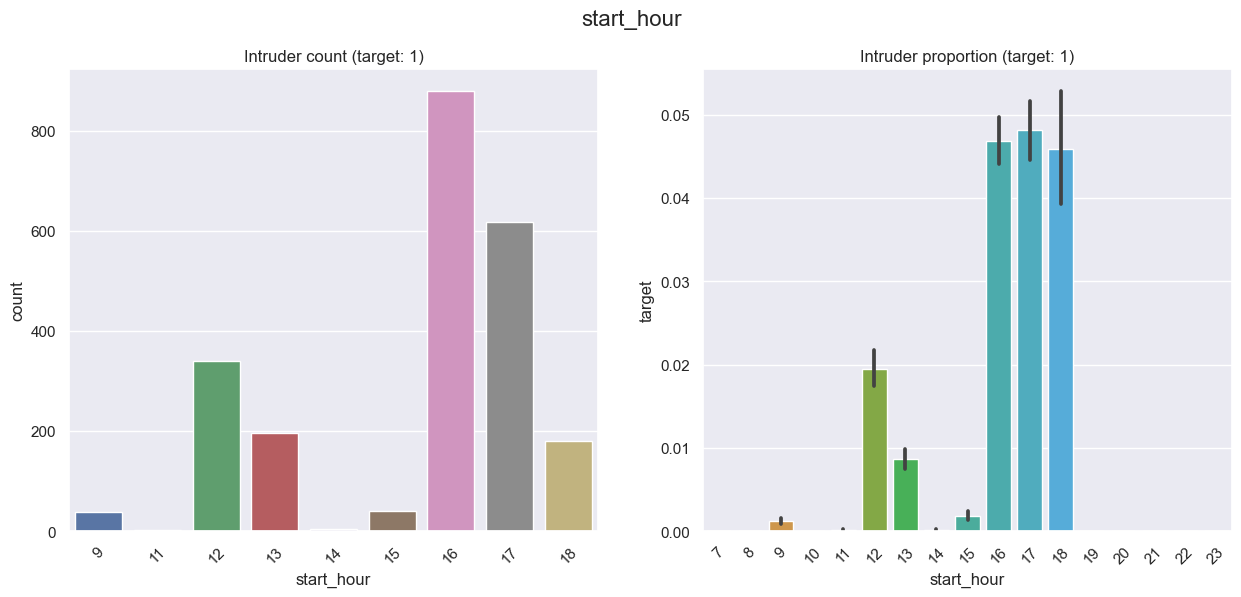

In [62]:
get_target_dist('start_hour')

Frauds were recorded between 9 and 18 hours, with the period from 16 to 18 hours most saturated with suspicious activity. On the basis of this, we will distinguish 3 features:

- morning: 7 - 11
- midday: 12 - 15
- evening: 16 - 20

In [63]:
add_data_train ['morning']  = add_data_train['start_hour'].apply(lambda hour:int(hour >= 7 and hour <= 11 )) 
add_data_train ['midday']   = add_data_train['start_hour'].apply(lambda hour:int(hour >= 12 and hour <= 18)) 
add_data_train ['evening']  = add_data_train['start_hour'].apply(lambda hour:int(hour >= 19 and hour <= 23))
add_data_train ['night']    = add_data_train['start_hour'].apply(lambda hour:int(hour >= 0 and hour <= 6))

add_data_test ['morning']  = add_data_test['start_hour'].apply(lambda hour:int(hour >= 7 and hour <= 12 )) 
add_data_test ['midday']   = add_data_test['start_hour'].apply(lambda hour:int(hour >= 12 and hour <= 18)) 
add_data_test ['evening']  = add_data_test['start_hour'].apply(lambda hour:int(hour >= 19 and hour <= 23))
add_data_test ['night']    = add_data_test['start_hour'].apply(lambda hour:int(hour >= 0 and hour <= 6))

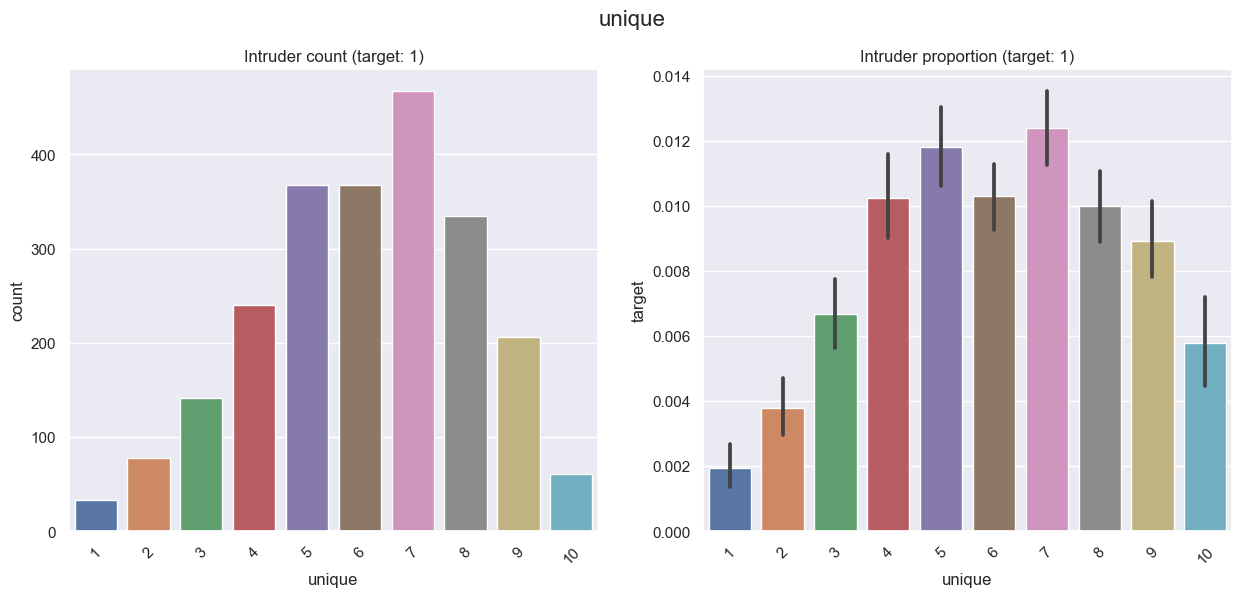

In [64]:
get_target_dist('unique')

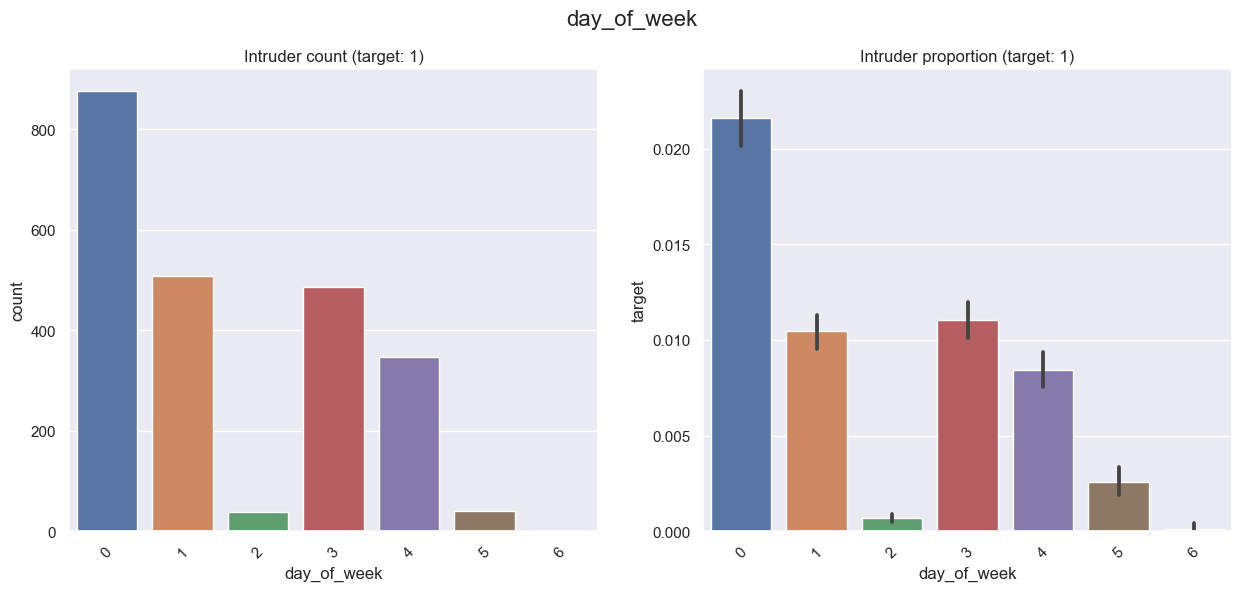

In [65]:
get_target_dist('day_of_week')

**The least suspicious activity was on Wednesdays, Saturdays and Sundays. But on Mondays(0), on the contrary, more than on other days.**

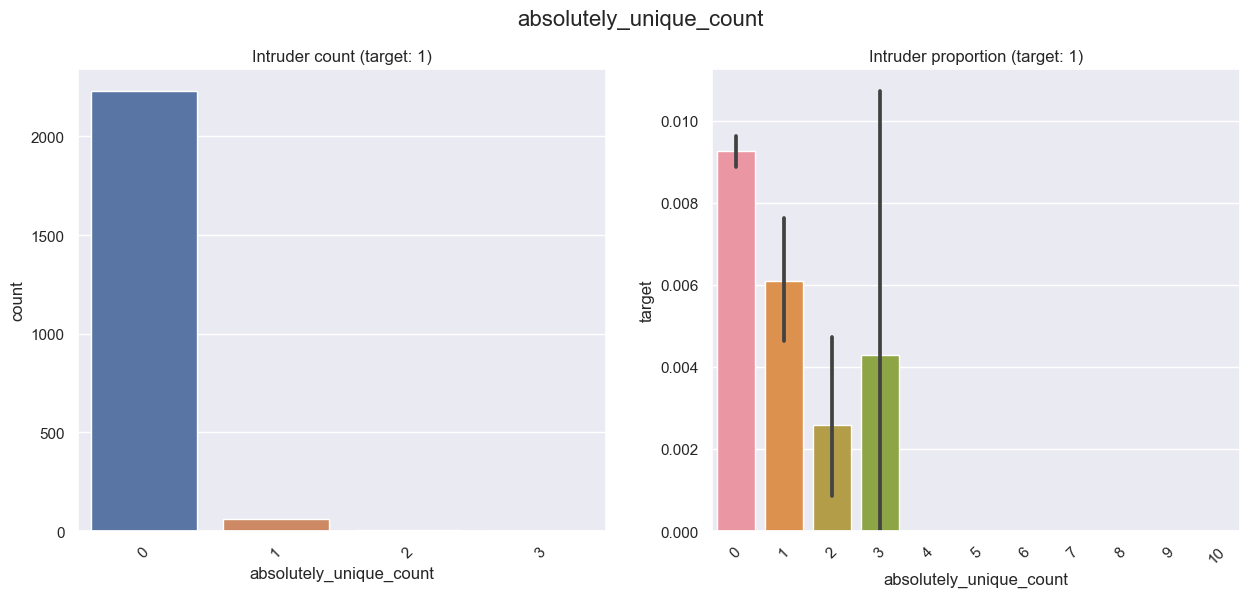

In [66]:
get_target_dist('absolutely_unique_count')

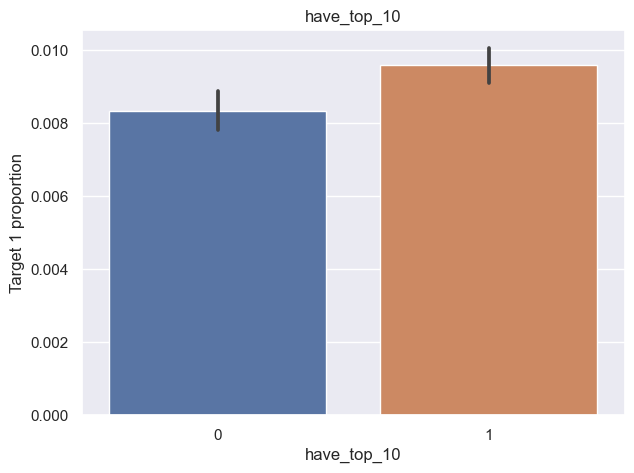

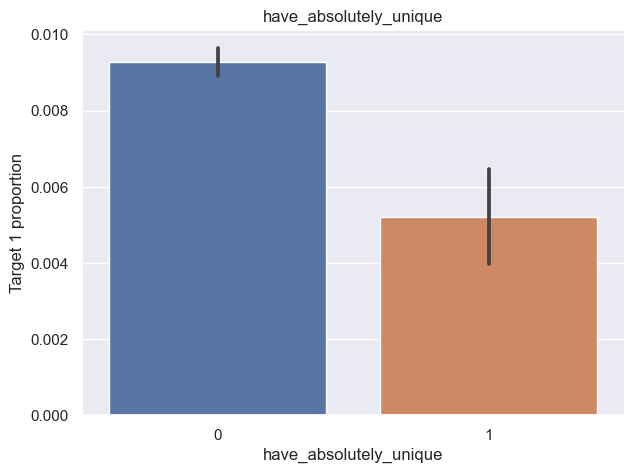

In [67]:
feature_list = ['have_top_10', 'have_absolutely_unique']
for column_name in feature_list:
    plt.figure(figsize=(7, 5))
    ax = sns.barplot(x=column_name, y="target", data=add_data_train)
    ax.set(ylabel='Target 1 proportion')
    plt.title(column_name)
    plt.show()

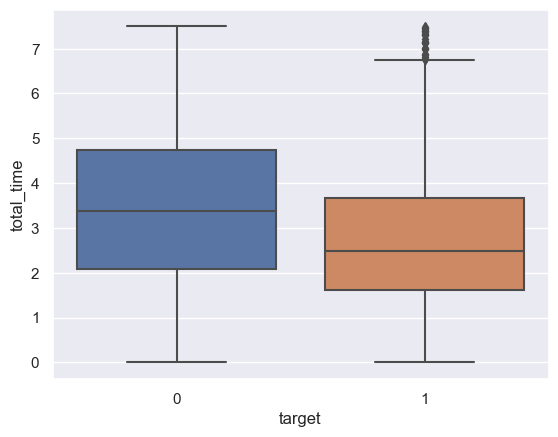

In [68]:
ax = sns.boxplot(x = 'target', y = 'total_time', data = add_data_train)

The duration of sessions with suspicious activity is on average less than that of the usual ones.

**General observations:**

- Most often, suspicious activity was seen between 16 and 18 hours
- Also on Mondays, suspicious activity occurs most often
- On average, the duration of sessions with suspicious activity is less than that of conventional
- Suspicious sessions are less common absolutely unique sites (sites that occur only once in the history of visiting sites)

 Adding Cyclic Co-ordinates

In [69]:
pi = np.pi
add_data_train['hour_sin_x'] = add_data_train['start_hour'].apply(lambda ts: np.sin(2*pi*ts/24.))
add_data_train['hour_cos_x'] = add_data_train['start_hour'].apply(lambda ts: np.cos(2*pi*ts/24.))

add_data_test['hour_sin_x'] = add_data_test['start_hour'].apply(lambda ts: np.sin(2*pi*ts/24.))
add_data_test['hour_cos_x'] = add_data_test['start_hour'].apply(lambda ts: np.cos(2*pi*ts/24.))

In [70]:
def kmeansshow(k,X):

    from sklearn import cluster
    from matplotlib import pyplot

    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(X)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    #print centroids

    for i in range(k):
        # select only data observations with cluster label == i
        ds = X[np.where(labels==i)]
        # plot the data observations
        pyplot.plot(ds[:,0],ds[:,1],'o')
        # plot the centroids
        lines = pyplot.plot(centroids[i,0],centroids[i,1],'kx')
        # make the centroid x's bigger
        pyplot.setp(lines,ms=15.0)
        pyplot.setp(lines,mew=2.0)
    pyplot.legend()
    pyplot.show()
    return centroids


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


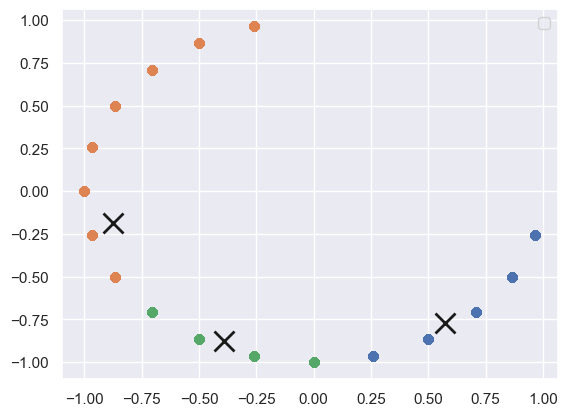

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


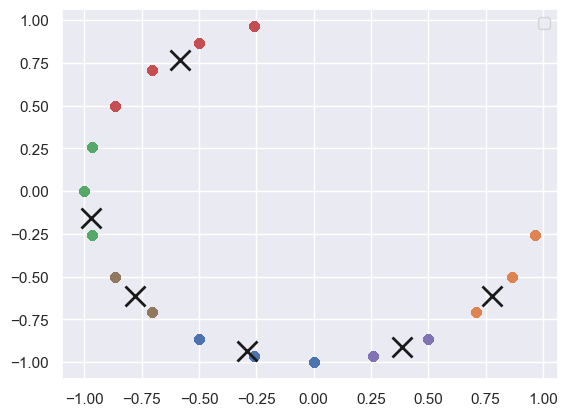

array([[-0.28969183, -0.9342021 ],
       [ 0.7788177 , -0.61299253],
       [-0.97319653, -0.1599555 ],
       [-0.58219335,  0.76509386],
       [ 0.38479246, -0.91374593],
       [-0.7808574 , -0.61099311]])

In [71]:
kmeansshow(3,add_data_train[['hour_sin_x', 'hour_cos_x']].values)
kmeansshow(6,add_data_train[['hour_sin_x', 'hour_cos_x']].values)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


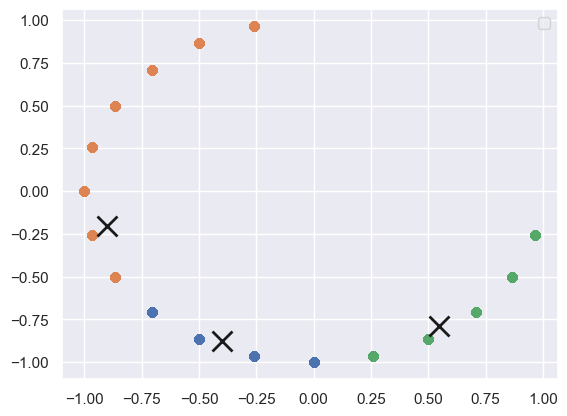

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


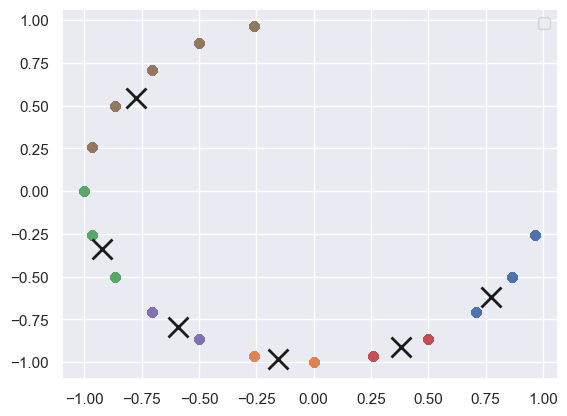

array([[ 0.77500356, -0.61679406],
       [-0.15576428, -0.97949324],
       [-0.92262679, -0.33759466],
       [ 0.38182786, -0.91497391],
       [-0.59041543, -0.7966472 ],
       [-0.77362894,  0.54194207]])

In [72]:
kmeansshow(3,add_data_test[['hour_sin_x', 'hour_cos_x']].values)
kmeansshow(6,add_data_test[['hour_sin_x', 'hour_cos_x']].values)

### Preprocessing data 
- Convert categorical variables to dummies using get_dummies

In [73]:
add_train_dummies  = pd.get_dummies(add_data_train , columns=['day_of_week']) 
add_train_dummies.drop(['target'],axis = 1,inplace=True) 
add_test_dummies  = pd.get_dummies(add_data_test,columns=['day_of_week'])

In [74]:
idx_split

253561

In [75]:
names_for_scale  =  ['time_diff' + str(x) for x in range (1,10)]  +  ['unique','absolutely_unique_count','total_time'] 
scaler = StandardScaler() 
for column_name in names_for_scale : 
    add_train_dummies[column_name] =scaler.fit_transform(add_train_dummies[column_name].values.reshape(-1,1)) 
    add_test_dummies[column_name]  =scaler.transform(add_test_dummies[column_name].values.reshape(-1,1))

In [76]:
# Sequence with indexes 
sites_flatten = full_sites.values.flatten()
# 
full_sites_sparse=csr_matrix(([1]  *  sites_flatten . shape [ 0 ], sites_flatten ,  
                                range(0,sites_flatten.shape[0]+10,10)))[:,1:]

X_train_sparse  =  full_sites_sparse [: idx_split ] 
X_test_sparse  =  full_sites_sparse [ idx_split :] 
full_sites_sparse.shape #(336358, 48371)

(336358, 48371)

In [79]:
full_sites = full_df[sites].astype('str')
lst = full_sites[sites].values.tolist()
flat_list = [' '.join(sublist) for sublist in lst]
vect = TfidfVectorizer(ngram_range=(1,4), max_features=100000,analyzer='char_wb')
tfidf_matrix = vect.fit_transform(flat_list)

X_train_tf = tfidf_matrix[:idx_split]
X_test_tf  = tfidf_matrix[idx_split:]

X_train_tf.shape, X_test_tf.shape

((253561, 13321), (82797, 13321))

In [86]:
# Convert all columns in the dummy variables to numeric (if needed)
add_train_dummies = add_train_dummies.apply(pd.to_numeric, errors='coerce')
add_test_dummies = add_test_dummies.apply(pd.to_numeric, errors='coerce')
# Convert all boolean columns to 0 and 1
add_train_dummies = add_train_dummies.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
add_test_dummies = add_test_dummies.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)


In [87]:
print(add_train_dummies.dtypes)

unique                     float64
have_top_10                  int32
absolutely_unique_count    float64
have_absolutely_unique       int32
time_diff1                 float64
time_diff2                 float64
time_diff3                 float64
time_diff4                 float64
time_diff5                 float64
time_diff6                 float64
time_diff7                 float64
time_diff8                 float64
time_diff9                 float64
total_time                 float64
start_hour                   int64
holiday                      int32
morning                      int64
midday                       int64
evening                      int64
night                        int64
hour_sin_x                 float64
hour_cos_x                 float64
day_of_week_0                int32
day_of_week_1                int32
day_of_week_2                int32
day_of_week_3                int32
day_of_week_4                int32
day_of_week_5                int32
day_of_week_6       

**Combine the site matrix and additional features**

In [88]:
x_train_full  =  csr_matrix(hstack([X_train_tf,add_train_dummies.values])) 
x_test_full   =  csr_matrix(hstack([X_test_tf ,add_test_dummies.values])) 
x_train_full.shape,x_test_full.shape

((253561, 13350), (82797, 13350))

![Image](https://hsto.org/webt/8i/5k/vx/8i5kvxrehatyvf-l3glz_-ymhtw.png)

In [89]:
target = train_df['target']
X_train , X_valid , y_train , y_valid = train_test_split(x_train_full,target ,test_size=0.2) 
tscv = TimeSeriesSplit(n_splits = 5)

In [90]:
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [91]:
[(el[0].shape, el[1].shape) for el in tscv.split(X_train)]

[((33808,), (33808,)),
 ((67616,), (33808,)),
 ((101424,), (33808,)),
 ((135232,), (33808,)),
 ((169040,), (33808,))]

**Since our classes are highly unbalanced, the accuracy metric here does not fit.**

**We will use ROC_AUC as a metric, and also look at the results of confusion_matrix**

Since we have historical data, interrelated with time, the standard cross-fitting in this case will not work. We will use cross-validation with TimeSeriesSplit - cross-validation techniques for time series. 
Its essence lies in the following: we divide the sample, for example, into 5 parts: [1, 2, 3, 4, 5], then we train in the following way

- Fold 1: training [1], Test [2]
- Fold 2: Training [1, 2], Test [3]
- Fold 3: teaching [1, 2, 3], Test [4]
- Fold 4: training [1, 2, 3, 4], Test [5]

**This approach will help to better evaluate the quality of the algorithm.**

In [92]:
%%time
clf_lr = LogisticRegression (random_state = 42, n_jobs=1, solver='lbfgs', max_iter=8000)
clf_lr.fit (X_train, y_train)
preds_lr = clf_lr.predict_proba (X_valid)[:, 1]
print ('Train test split LogisticRegression score:% s ROC AUC'% round (roc_auc_score (y_valid, preds_lr), 4))
cross_score_lr = np.mean (cross_val_score (clf_lr, x_train_full, target, scoring = 'roc_auc', cv = tscv))
print ('Cross validation LogisticRegression score:% s ROC AUC'% round (cross_score_lr, 4))

Train test split LogisticRegression score:0.9774 ROC AUC
Cross validation LogisticRegression score:0.9145 ROC AUC
CPU times: total: 7min 33s
Wall time: 3min 30s


In [93]:
%%time
clf_rf = RandomForestClassifier (random_state = 42, n_estimators = 100)
clf_rf.fit (X_train, y_train)
preds_rf = clf_rf.predict_proba (X_valid) [:, 1]
print ('Train test split RandomForestClassifier score:% s ROC AUC'% round (roc_auc_score (y_valid, preds_rf), 4))
cross_score_rf = np.mean (cross_val_score (clf_rf, x_train_full, target, scoring = 'roc_auc', cv = tscv))
print ('Cross validation RandomForestClassifier score:% s ROC AUC'% round (cross_score_rf, 4))

Train test split RandomForestClassifier score:0.9787 ROC AUC
Cross validation RandomForestClassifier score:0.845 ROC AUC
CPU times: total: 7min 35s
Wall time: 14min 40s


In [98]:
%%time
reg_xgb = xgb.XGBRegressor(10, 0.1, 1000, objective= 'binary:logistic', random_state = 42, booster = 'gblinear',scale_pos_weight = 109)
reg_xgb.fit(X_train, y_train)
preds_xgb_reg = reg_xgb.predict(X_valid)

CPU times: total: 5min 55s
Wall time: 56.7 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [99]:
preds_xgb_reg = reg_xgb.predict(X_valid)

In [100]:
preds_xgb_reg.shape

(50713,)

In [101]:
print ('Train test split XGBRegressor score:% s ROC AUC'% round (roc_auc_score (y_valid, preds_xgb_reg), 4))
cross_score_xgb_reg = np.mean (cross_val_score (reg_xgb, x_train_full, target, scoring = 'roc_auc', cv = tscv))
print ('Cross validation XGBRegressor score:% s ROC AUC'% round (cross_score_xgb_reg, 4))

Train test split XGBRegressor score:0.9694 ROC AUC
Cross validation XGBRegressor score:0.88 ROC AUC


In [102]:
%%time
clf_xgb = xgb.XGBClassifier (random_state = 42, booster = 'gblinear')
clf_xgb.fit (X_train, y_train)
preds_xgb = clf_xgb.predict_proba (X_valid) [:, 1]
print ('Train test split XGBClassifier score:% s ROC AUC'% round (roc_auc_score (y_valid, preds_xgb), 4))
cross_score_xgb = np.mean (cross_val_score (clf_xgb, x_train_full, target, scoring = 'roc_auc', cv = tscv))
print ('Cross validation XGBClassifier score:% s ROC AUC'% round (cross_score_xgb, 4))

Train test split XGBClassifier score:0.9769 ROC AUC
Cross validation XGBClassifier score:0.8252 ROC AUC
CPU times: total: 3min 21s
Wall time: 30.9 s


Text(0.5, 0, 'False Positive Rate')

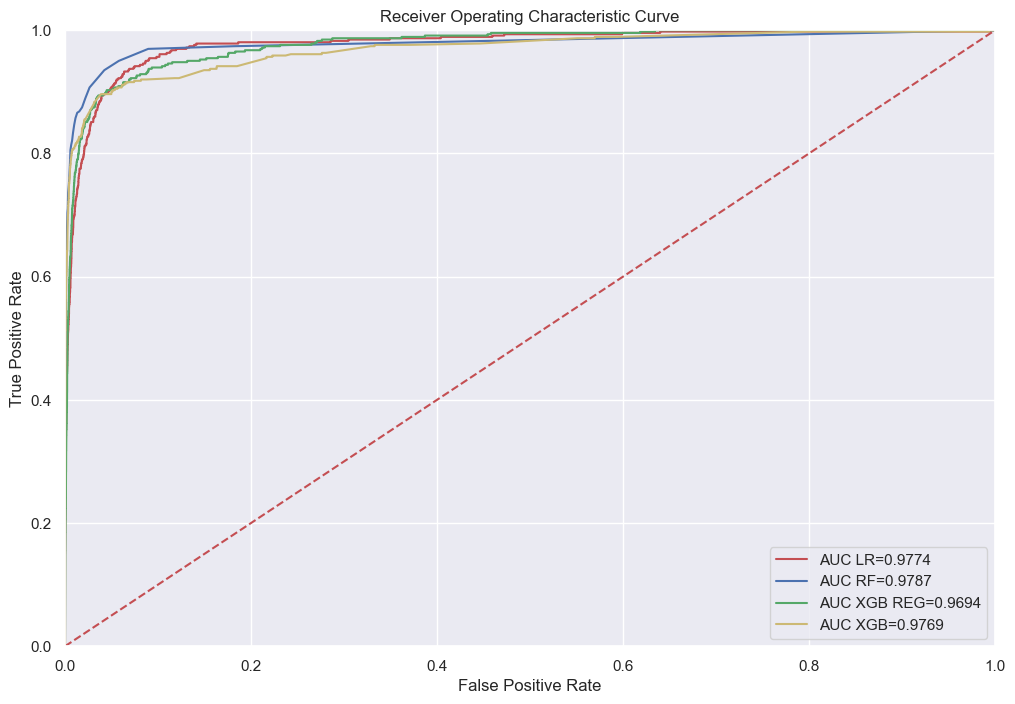

In [104]:
fpr_lr,tpr_lr,threshold=roc_curve(y_valid,preds_lr)
roc_auc_lr = auc(fpr_lr,tpr_lr)

fpr_rf,tpr_rf,threshold=roc_curve(y_valid,preds_rf)
roc_auc_rf = auc(fpr_rf,tpr_rf)

fpr_xgb_reg,tpr_xgb_reg,threshold=roc_curve(y_valid,preds_xgb_reg)
roc_auc_xgb_reg = auc(fpr_xgb_reg,tpr_xgb_reg)

fpr_xgb,tpr_xgb,threshold=roc_curve(y_valid,preds_xgb)
roc_auc_xgb = auc(fpr_xgb,tpr_xgb)

plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr_lr, tpr_lr,'r', label='AUC LR=%0.4f'%roc_auc_lr)
plt.plot(fpr_rf, tpr_rf,'b', label='AUC RF=%0.4f'%roc_auc_rf)
plt.plot(fpr_xgb, tpr_xgb,'g', label='AUC XGB REG=%0.4f'%roc_auc_xgb_reg)
plt.plot(fpr_xgb_reg, tpr_xgb_reg, 'y', label='AUC XGB=%0.4f'%roc_auc_xgb)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [105]:
def show_confusion_matrix(y_true,y_pred,title='Confusionmatrix'):
    table=confusion_matrix(y_true.values,y_pred)
    fig,ax=plt.subplots(frameon=False)
    fig.set_size_inches(4,3)
    fig.suptitle(title,fontsize=20)
    ax.axis('off')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    the_table=ax.table(cellText=table,
                        colWidths=[0.5]*len([0,1]),
                        rowLabels=['True 0','True 1'],colLabels=['Predicted 0','Predicted 1'],
                        cellLoc='center',rowLoc='center',loc="center")
    the_table.set_fontsize(34)
    the_table.scale(1,4)
    plt.show()

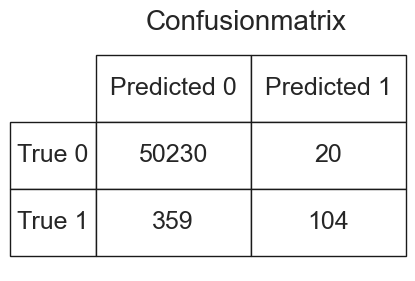

In [106]:
show_confusion_matrix(y_valid, clf_lr.predict(X_valid))

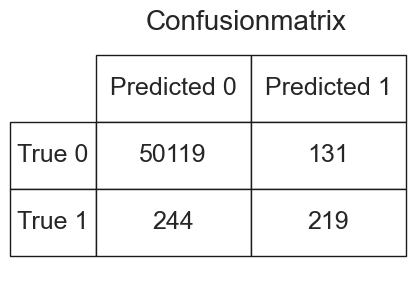

In [107]:
show_confusion_matrix(y_valid, clf_xgb.predict(X_valid))

In [108]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed,max_iter=8000,n_jobs=1,solver='lbfgs').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    return score

In [109]:
%%time
from tqdm import tqdm
# List of possible C-values
Cs = np.logspace(-1, 1, 20)

scores = []

for C in tqdm(Cs):
     scores.append(get_auc_lr_valid(X_train, y_train, C=C))

100%|██████████| 20/20 [21:02<00:00, 63.13s/it] 

CPU times: total: 46min 34s
Wall time: 21min 2s


In [110]:
Cs

array([ 0.1       ,  0.1274275 ,  0.16237767,  0.20691381,  0.26366509,
        0.33598183,  0.42813324,  0.54555948,  0.6951928 ,  0.88586679,
        1.12883789,  1.43844989,  1.83298071,  2.33572147,  2.97635144,
        3.79269019,  4.83293024,  6.15848211,  7.8475997 , 10.        ])

In [111]:
scores, max(scores), Cs[np.argmax(scores)]

([0.9582280376937891,
  0.9618352845483125,
  0.9649672319423103,
  0.967566756478859,
  0.9698828505723,
  0.9719852102332329,
  0.9738188986062438,
  0.9754957026259817,
  0.9770093359856082,
  0.978390956901627,
  0.9796495848577628,
  0.9807196236087448,
  0.9816510902915918,
  0.982453551025406,
  0.9832013482214945,
  0.9838687900171261,
  0.9844657158490915,
  0.9850369498183258,
  0.9855373945062053,
  0.9859984814469219],
 0.9859984814469219,
 10.0)

In [112]:
final_model = LogisticRegression(random_state = 17, C = Cs[np.argmax(scores)],n_jobs=1) 
final_model.fit(X_train,y_train) 
print('ROC_AUC on the test sample: {} '.format(round(roc_auc_score(y_valid,final_model.predict_proba(X_valid)[:,1]),4)))

ROC_AUC on the test sample: 0.9671 


In [113]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [119]:
pred_1 = final_model.predict(x_test_full)

0

In [128]:
np.unique(pred_1,return_counts=True)

(array([0, 1], dtype=int64), array([82619,   178], dtype=int64))

In [114]:
preds = final_model.predict_proba(x_test_full)[:,1]

In [115]:
preds[:10]

array([4.46550840e-05, 6.37899848e-06, 1.67940911e-03, 4.54649005e-06,
       8.59510145e-04, 7.31592536e-06, 6.07395844e-05, 7.07690649e-05,
       3.29659771e-05, 9.27171784e-04])

In [116]:
preds = np.where(preds > 0.945, 0.985, preds)

In [117]:
write_to_submission_file(preds,'re-git_v4.csv')

### Hope it was Useful (More To Come, till then Enjoy and share your Views Below...****)

Thanks

- *Aditya Soni*